# Graph Analysis - Mathieu VANDECASTEELE

# Université de Rouen - M2 SID Janv. 2019

In [1]:
# Import utiles
from graph import *
from mcs import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.cbook
import warnings
from networkx.algorithms import approximation
warnings.filterwarnings("ignore")

**L'objectif** de ce notebook est :
* de présenter la classe Graph développée en première partie de l'EC Graph Analysis indépendante de NetworkX.
* d'illustrer l'implémentation de MCS - Maximum Commun Subgraph en Python. Plus précisement le Maximum Common **Induced** Subgraph.

# 1. Classe Graph

J'ai créé des fonctions dans le but de faire des graphs sans networkx mais à savoir que j'ai fais en sorte que ma classe Graph soit convertible en Graph networkx a tout instant !

Création de Graphs et ajout de edges :

In [2]:
# Graph types : "directed_weighted", "directed", "undirected_weighted", "simple"

g = Graph("undirected")
list_edges = [('a','b'),('b','c'),('c','e'),('e','d'),('b','d'),('d','g'),('g','f'),('a','f'),('d','c'),('e','b')]
g.add_edges_from_list(list_edges)

g2 = Graph("undirected_weighted")
list_edges2 = [('e','f',4),('f','a',3),('a','b',6),('b','d',1),('d','c',2),('c','a',5),('b','g',4),('d','h',2),('b','c',2),('d','a',2)]
g2.add_edges_from_list(list_edges2)

Accès aux attributs :

In [3]:
print(g.vertices)
print(g.type)
#print(g.edges)

['a', 'b', 'c', 'e', 'd', 'g', 'f']
undirected


Affichage :

In [4]:
# La classe est indépendant de NetworkX. Cependant, pour afficher nous allons convertir nos graphs en graphs NetworkX. 
# Il est donc possible de créer un dictionnaire à partir des edges et vertices pour un graph :

g.build_graph_dictionary()
g2.build_graph_dictionary()

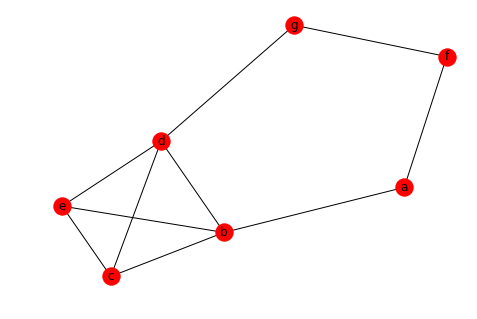

In [5]:
display_graph(g)

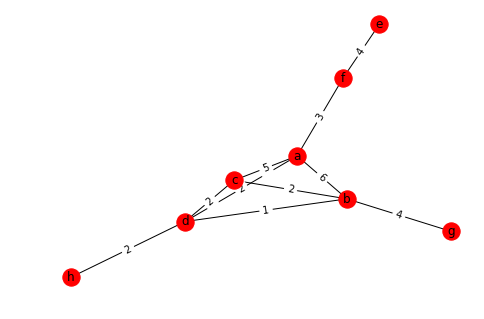

In [6]:
display_graph(g2)

Conversion en Graph NetworkX :

In [7]:
G = nx.Graph(g.graphdic)

Affichage direct d'un Graph NetworkX :

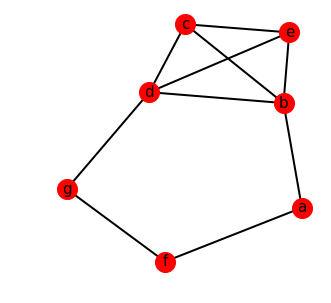

In [8]:
display_nxgraph(G)

Cette boîte à outils pourra être enrichie avec de nousvelles fonctionnalités. Pour la suite du TP, nous abordons un sujet totalement différent et nous allons nous baser sur des graphs NetworkX

# 2. Maximum Common Induced Subgraph

**Définition de Wikipédia d'un Induced Subgraph :**

*Formally, let G = (V, E) be any graph, and let S ⊂ V be any subset of vertices of G. Then the induced subgraph G[S] is the graph whose vertex set is S and whose edge set consists of all of the edges in E that have both endpoints in S. The same definition works for undirected graphs, directed graphs, and even multigraphs.*

*The induced subgraph G[S] may also be called the subgraph induced in G by S, or (if context makes the choice of G unambiguous) the induced subgraph of S.*


Donc, après interprétation **il s'agit de graphes dont on a enlevé des vertex depuis un graphe d'origine et donc tous les edges reliés à ce dernier. On enlève pas de edges entre deux noeux non-retirés.**

Maximum Common Induced Subgraph est NP-Hard. Probablement que cela va demander beaucoup de ressources donc nous aborderons des graphes avec **maximum 25 vertex**.
Le but est donc d'approximer une solution.

Les difficultés vont résider dans :
* l'optimisation du **nombre de combinaisons** de vertex à retirer, car tester toutes les combinaisons va impliquer beaucoup de ressources vu que l'ajout d'un vertex supplémentaire de base dans un graph multiplie par 2 le nombre de combinaisons possibles.
* La mesure de la **simmilarité** entre deux induced subgraphs qui peut prendre du temps.
* Plusieurs Induced Subgraph seront retournés en sortie, comment prendre une **décision** et en choisir un seul ? 

## Ma solution

* Lister tous les sous-graphes possibles d'un Graph avec des déletions de vertex.
* Faire de même avec un second Graph.
* Comparer les deux listes de sous-graphes avec un calcul de similarité, on retourne tous les graphes identiques 2 à 2.
* On retourne une des solutions ayant le plus de vertex possible.

### Optimisations qui ont été réalisées :

Si l'on procède ainsi, rien que des graphs de 10 vertices va prendre beaucoup de temps bien que cela va marcher. Ce que j'ai réalisé pour améliorer mon processus et gagner du temps :
* Pour optimiser le nombre de combinaisons testées, j'ai fais deux choix :
    * Utiliser un paramètre manuel du nombre de vertices minimum que l'on souhaite retrouver, ce qui peut au final de mener à aucun résultat mais en général si
        on applique un nombre de vertices deux fois inférieurs au nombre de vertices total on trouvera une solution. Cela permet de retirer toutes les petites solutions comme les graphs de 1 et 2 vertex-ices à minima. Le paramètre de base est d'ailleurs par défaut à 3.
    * Utiliser la maximum clique des deux graphs. En effet sa taille peut servir de valeur pour le paramètre manuel précédent et on peut se base dessus pour construire les combinaisons en ne prenant que des combinaisons possédant au moins les noeuds de cette clique. Cela peut également aider au processus de décision final car on réduit encore une fois le champs global des possibilités.
    * Exclure les Graphs non-connexes. On n'inclut que les graphes connexes dans les combinaisons.
* Pour gagner du temps dans le calcul de similarités, je suis passé de la fonction nx.graph_edit_distance() implémentée de base dans NetworkX à une fonction moi-même implémentée basée sur les matrices Laplaciennes des graphs et ses valeurs propres décrite ici : https://www.cs.cmu.edu/~jingx/docs/DBreport.pdf

In [9]:
M = nx.dense_gnm_random_graph(10,23)
M2 = nx.dense_gnm_random_graph(9,23)

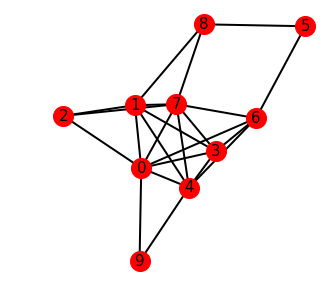

In [10]:
display_nxgraph(M)

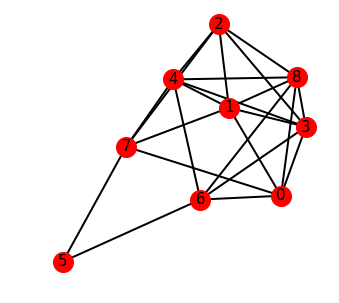

In [11]:
display_nxgraph(M2)

In [20]:
communs = my_mcs(M,M2,3,False)

Combinaisons en construction...
Nombre de combinaisons Graph 1 :
968
Nombre de combinaisons Graph 2 :
466
Terminé!
Extraction des Induced Subgraphs...
Terminé!
Distances...
Terminé!


In [21]:
len(communs)

1699

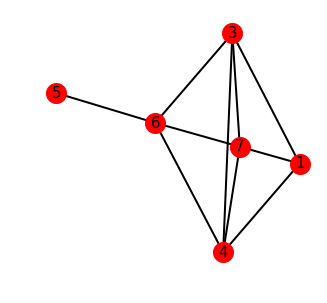

In [28]:
display_nxgraph(communs[1698][0])

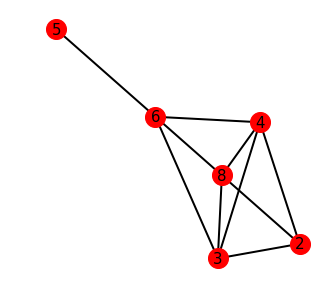

In [27]:
display_nxgraph(communs[1698][1])

**On teste en activant le filtre par max_clique :**

In [14]:
communs_withmaxclique = my_mcs(M,M2,3,True)

Combinaisons en construction...
Nombre de combinaisons Graph 1 :
968
Nombre de combinaisons Graph 2 :
466
Terminé!
Nombre de combinaisons Graph 1 après max_clique :
32
Nombre de combinaisons Graph 2 après max_clique :
16
Extraction des Induced Subgraphs...
Terminé!
Distances...
Terminé!


In [15]:
len(communs_withmaxclique)

1

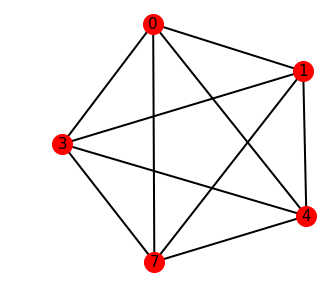

In [18]:
display_nxgraph(communs_withmaxclique[0][0])

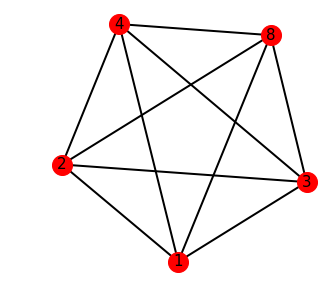

In [19]:
display_nxgraph(communs_withmaxclique[0][1])

# Conclusion

L'algorithme de base prend du temps mais a + de chances de retourner à la fin une solution plus optimale du problème. Souvent il retourne même plusieurs résultats possible, il va falloir se poser alors le problème de décisions. Le filtre avec max_clique permet de rendre quazi instantanée la recherche mais elle peut engendrer des résultats moins satisfaisants et ne rien retourner parfois, il faut jouer plus avec les paramètres.


**Pistes d'améliorations :**
* Pour rendre max_clique plus pertinent, il faudrait trouver une solution pour choisir la max_clique la plus adaptée au problème. En effet, bien que nous prenons des max_clique de même taille pour les deux graphs, nous choisissons abritrairement la max_clique finale que l'on va utiliser comme filtre. Il faudrait sûrement utiliser les degrées des noeuds ou le domination set.